# Decision Making I

## Céline Budding && Dorothea Müller 

In [1]:
import numpy as np
import matplotlib as mlp
import matplotlib.pyplot as plt

%matplotlib inline

### 1. Extension-Drift Model

### 1.

In [36]:
def euler_maruyama(ffun, gfun, x0, t, **args):
    """Euler Maruyama method for stochastic differential equations. x0 must be a list."""
    dts = np.diff(t).astype(float)
    res = np.zeros((len(t), len(x0)))
    res[0] = x0
    
    for i in range(1, len(t)-1):
        # Euler part.
        res[i] = np.multiply(ffun(res[i-1], t, **args), dts[i]) + res[i-1]
        
        gfun_res = gfun(res[i-1], t, **args)
        if isinstance(gfun_res, float) or isinstance(gfun_res, int):
            gfun_res = np.repeat(gfun_res, res[i].shape[0])
        
        # For each component, sample from random normal distribution!
        rand_vals = np.random.normal(0, 1, res[i].shape[0])
        
        for j, _ in enumerate(res[i]):
            # For each component, sample noise independently from random normal distribution.
            res[i, j] = res[i, j] + gfun_res[j] * rand_vals[j] * np.sqrt(dts[i])
    return res

In [37]:
x0 = [0]
sigma = 0.5
mu = 0.2
t = np.linspace(0, 10, 1001)
n_sm = 5

In [38]:
ffn = lambda x, t, **args: args['mu']
gfn = lambda x, t, **args: args['sigma']

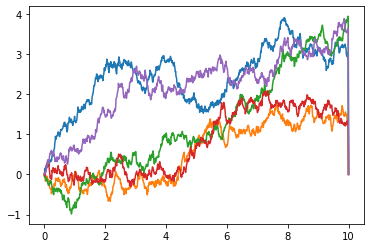

In [39]:
for run in range(n_sm):
    res = euler_maruyama(ffn, gfn, x0, t, sigma = 0.5, mu = 0.2)
    plt.plot(t, res)

### 2.

In [40]:
def simulate_up(a = 1, mu_val= [-0.1, 0, 0.1, 0.2, 0.5], n=200, sigma=0.5):

    perc_up = np.zeros(len(mu_val))
    res = np.zeros(len(t))
    
    for i, mu in enumerate(mu_val):
    
        n_successfull = 0
        for _ in range(n):
            
#             res[-2] = 0
#             # Resample when no decision boundary is found
#             while(res[-2] < a and res[-2] > -a):
#                 res = euler_maruyama(ffn, gfn, x0, t)
            res = euler_maruyama(ffn, gfn, x0, t, mu = mu, sigma=sigma)
        
            if res[-2] > a:
                n_successfull +=1

        perc_up[i] = n_successfull/n  * 100
        
    return perc_up

In [41]:
mu_val = [-0.1, 0, 0.1, 0.2, 0.5]
a_val = [0.5, 1, 2]
n = 200

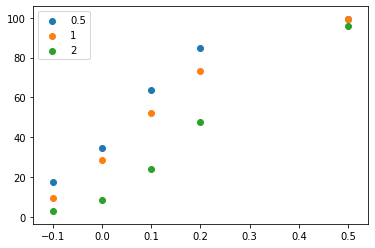

In [42]:
for a in a_val:
    res_a = simulate_up(a = a)
    plt.scatter(mu_val, res_a, label = f"{a}")

plt.legend()

We will pick a value of mu = 0.2 to reach 70% up-trials because we know a = 1 in the next exercise.

## TODO: ask about resampling.